# Introduction to Data Science - Homework 4
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, February 9, 11:59pm.

In this homework you will download SLC air quality data and compute a moving average. Then you'll complete an A/B test comparing two ads. 

## Your Data
Fill out the following information: 

*First Name:*  Rebecca <br>
*Last Name:*   Rodriguez <br>


In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Part 1: SLC Air Quality Index 

In this problem, you'll study the Air Quality at Hawthorn Elementary School in Salt Lake City. 

### Task 1.0.  Learn about AQI

Read about air quality in SLC here: http://slcair.communication.utah.edu/


### Task 1.1. Download data
The EPA gives access to air quality data on the AirData website. Become familiar with the cite by reading this [information page](https://www.epa.gov/outdoor-air-quality-data/air-data-basic-information).


Go to [this website](https://www.epa.gov/outdoor-air-quality-data/download-daily-data) and download the following daily data: 
1. Pollutant = PM2.5
+ Year = 2017
+ City = Salt Lake City, UT
+ Monitor Site = 490353006 (Hawthorn Elementary School)



### Task 1.2. Import the data 
Use the pandas.read_csv() function to import the data

A word of warning: this data isn't very clean:

1. The dates are not sorted. 
+ some dates may have missing values.
+ some dates may have multiple values corresponding to different collection sites (POC=1,4,5).   


In [12]:
#import csv into df
hawth = pd.read_csv("Hawthorne_Air_2017.csv")

#sort data by date
hawth = hawth.sort_values("Date")

#rename columns
hawth = hawth.rename(index=str, columns={"AQS_SITE_ID":"SITE","Daily Mean PM2.5 Concentration":"PM2.5", "DAILY_AQI_VALUE":"AQI", "DAILY_OBS_COUNT": "OBS", "AQS_PARAMETER_CODE":"AQS Code", "AQS_PARAMETER_DESC":"AQS Desc"})

#visually inspect data
hawth.head()
#hawth.info()
#hawth.describe()
#hawth["Date"].value_counts()   #max 3 values per day, min 2 values per day
#hawth["POC"].value_counts()

,Date,SITE,POC,PM2.5,UNITS,AQI,OBS,PERCENT_COMPLETE,AQS Code,AQS Desc,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
352,01/01/2017,490353006,4,30.6,ug/m3 LC,90,1,100.0,88101,PM2.5 - Local Conditions,41620,"Salt Lake City, UT",49,Utah,35,Salt Lake,40.736389,-111.872222
716,01/01/2017,490353006,5,32.6,ug/m3 LC,94,1,100.0,88101,PM2.5 - Local Conditions,41620,"Salt Lake City, UT",49,Utah,35,Salt Lake,40.736389,-111.872222
353,01/02/2017,490353006,4,8.6,ug/m3 LC,36,1,100.0,88101,PM2.5 - Local Conditions,41620,"Salt Lake City, UT",49,Utah,35,Salt Lake,40.736389,-111.872222
717,01/02/2017,490353006,5,11.8,ug/m3 LC,49,1,100.0,88101,PM2.5 - Local Conditions,41620,"Salt Lake City, UT",49,Utah,35,Salt Lake,40.736389,-111.872222
718,01/03/2017,490353006,5,13.6,ug/m3 LC,54,1,100.0,88101,PM2.5 - Local Conditions,41620,"Salt Lake City, UT",49,Utah,35,Salt Lake,40.736389,-111.872222


### Task 1.3. Plot the data

Plot the daily mean PM2.5 concentration and daily AQI value. Since there are multiple POCs for each day, plot the data in each of the following ways:
1. Average the daily mean PM2.5 concentration and daily AQI value over the POCs for each day. In a single figure, plot date vs. each of these two quantities. 
+ Make two plots, one for daily mean PM2.5 concentration and the other for daily AQI value. In the first plot, plot the daily mean PM2.5 concentration for each POC value (POC=1,4,5) seperately. In the second plot, plot the daily AQI value for each POC value (POC=1,4,5) seperately. 

*Hint*: use the pandas groupby function


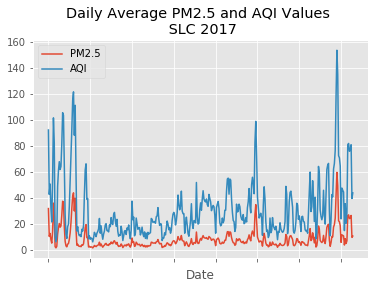

In [3]:
#Task 1.3, Part 1: plot pm2.5 and aqi (grp by date)

#smaller df containing date, pm2.5, aqi and poc
pm25_aqi = hawth[["Date","PM2.5", "AQI", "POC"]]
pm25_aqi.head(20)

#calc means of PM2.5 and AQI for each day
pmaq_grp_date = pm25_aqi.groupby("Date")
pm_means = pmaq_grp_date.mean()

#visually inspect data
#pm_means.head()
#pm_means.info()

#plot daily avg pm2.5 and aqi values
pm25_aqi_plot1 = pm_means[["PM2.5", "AQI"]].plot(title="Daily Average PM2.5 and AQI Values \n SLC 2017")


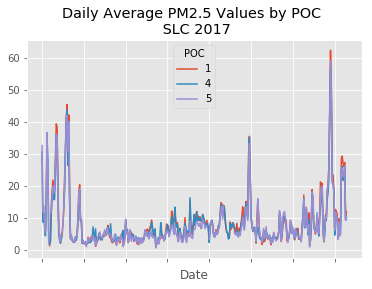

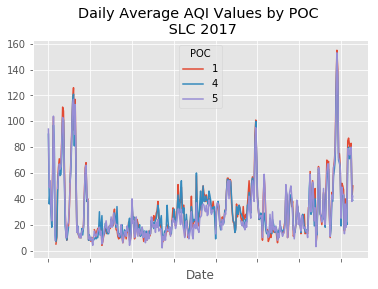

In [4]:
#Task 1.3, Part 2: plot pm2.5 and aqi (grp by date and poc)

#print(pm25_aqi.head())

#group by date and POC, sum the PM2.5 values (by date and POC)
pm25_poc_grp = pm25_aqi.groupby(['Date', "POC"]).sum()["PM2.5"].unstack()
pm25_poc_grp.plot(title="Daily Average PM2.5 Values by POC \n SLC 2017")

#group by date and POC, sum the AQI values (by date and POC)
aqi_poc_grp = pm25_aqi.groupby(['Date', "POC"]).sum()["AQI"].unstack()
aqi_poc_grp.plot(title="Daily Average AQI Values by POC \n SLC 2017")

#reference (thank the lord for Italian data scientists!)
#https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html


### Task 1.4. Plot a moving average

Make a plot with both the daily AQI value and a moving average for the daily AQI value. Use the daily AQI value that is averaged over the POC. Experiment with different time windows to find one that is reasonable.

*Hint:* Use the rolling() function as in Lecture 7. 

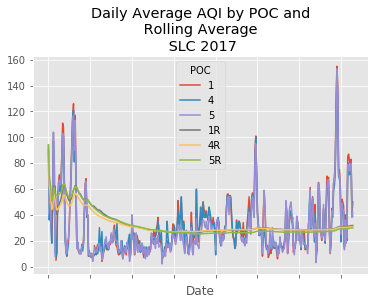

In [5]:
#calc rolling mean of avg daily aqi (by poc)
#chose window of 365 to reflect number of days in year
aqi_roll_mean = aqi_poc_grp.rolling(window=365, min_periods=1).mean()

#visually inspect/compare data
#print(aqi_poc_grp.tail(10))
#print(aqi_roll_mean.tail(10))

#combine both dfs into one df
combined_aqi = aqi_poc_grp
combined_aqi["1R"] = aqi_roll_mean[1]
combined_aqi["4R"] = aqi_roll_mean[4]
combined_aqi["5R"] = aqi_roll_mean[5]

#plot daily avg aqi and rolling avg
combined_aqi.plot(title="Daily Average AQI by POC and\n Rolling Average \n SLC 2017")


## Part 2: A/B testing

First read the WIRED article on A/B testing [here](http://www.wired.com/2012/04/ff_abtesting/).

Suppose your company is developing a new logo. The art department develops two logos: ‘Logo A’ and ‘Logo B’, shown below. 
![](http://www.wired.com/wiredenterprise/wp-content/gallery/20-05/ff_abtesting_f.jpg)
Your job is to figure out which logo is better. 


You decide to conduct the following experiment. You use Google ads to buy 2000 advertisements. In $N_A=1000$ of the ads (randomly chosen), you use Logo A and in the other $N_B=1000$ ads, you use Logo B. Then you see which logo attracts more clicks.

It turns out that $n_A=500$ Logo A viewers click on the ad while $n_B=550$ Logo B viewers click on the ad. Obviously Logo B did better in this test, but is the difference *significant* enough to say that Logo B is better? Or, perhaps, Logo B just got lucky in this test? 

The goal of this exercise will be to conduct a two-proportion z-test to determine if Logo B is better. The steps will be similiar to those from Lecture 8 used for the 1954 Salk polio-vaccine experiment.

### Task 2.1.  Formulate null hypothesis 

Let $p_A = n_A/N_A$ be the proportion of clicks on Logo A and similiarly $p_B$ be the proportion of clicks on Logo B. In terms of $p_A$ and $p_B$, clearly state the null and alternative hypothesis. 

**Your Solution:** 

Hypotheses:

$H_0 : p_A - p_B = 0$   

There is no difference between the proportion of viewers who clicked on logo A and the proportion of viewers who clicked on logo B. i.e. logo A and logo B did equally well among the viewers.

$H_A: p_A - p_B < 0$

The proportion of viewers who clicked on logo A is less than the proportion of viewers who clicked on logo B. i.e. logo B outperformed logo A among the viewers.


### Task 2.2.  Find the two-proportion z-value  

Assuming the null hypothesis, we know from lecture that the test statistic, called the *two-proportion z-value*,
$$
Z = \frac{p_A - p_B}{\sqrt{\hat{p} \hat{q} \left( \frac{1}{N_A} + \frac{1}{N_B} \right)}}.
$$
is approximately  distributed according to the standard normal distribution. Here $\hat{p} = \frac{N_A}{N_A + N_B}p_A + \frac{N_B}{N_A + N_B}p_B$ and $\hat{q} = 1-\hat{p}$. 


Find the two-proportion z-value.

In [6]:
#Task 2.2: calc two-proportion z-value (i.e. observed test statistic)

import math

#sample sizes and proportions
n_a = n_b = 1000
prop_a = 500/n_a
prop_b = 550/n_b

#calc p_hat and q_hat
p_hat = ((n_a/(n_a + n_b)) * prop_a) + ((n_b/(n_a + n_b)) * prop_b)
q_hat = 1 - p_hat

#calc z-val
z_val = (prop_a - prop_b) / (math.sqrt(p_hat*q_hat*((1/n_a) + (1/n_b))))
print("Observed z-value: ", z_val)

#rejection region for two sided test at sig lev = .05
lower_reject_05 = norm.ppf(.05)

#rejection region for two sided test at sig lev = .01
lower_reject_01= norm.ppf(.01)

#NOTE: we can see that H_0 is rejected at .05 level, but not at .01 level
#print(z_val < lower_reject_05)
#print(z_val < lower_reject_01)

#reference: Prob&Stats Ch9, P.348


Observed z-value:  -2.238868314198227


### Task 2.3. Complete the two proportion z-test 

Find the $p$-value for the hypothesis test.

In [7]:
#Task 2.3: calc p-val

#calc p-value: prob of obtaining value >= +z-val or <= -z-val
p_val = norm.cdf(z_val)
print("P-value: ", p_val)

P-value:  0.012582242850159199


### Task 2.4. Interpretation

Interpret the $p$-value in this example and  state the result of the hypothesis test at the $\alpha=5\%$ and $\alpha=1\%$ significance levels. 


**Your Interpretation:** 

**Results of hypothesis test at $\alpha = .05$ :**

Since the p-value = .0126 < .05 = significance level, we reject $H_0$ in favor of $H_A$; the sample data suggests that logo B was prefered over logo A among the viewers. 

**Results of hypothesis test at $\alpha = .01$ :**

Since the p-value = .0126 > .01 = significance level, we (barely) fail to reject $H_0$; the sample data does not provide sufficient evidence to suggest logo B  was prefered over logo A among the viewers. 